In [1]:
import IPython
IPython.get_ipython().magic("load_ext autoreload")
IPython.get_ipython().magic("autoreload 2")

/tmp/ipykernel_3333009/2580614648.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  IPython.get_ipython().magic("load_ext autoreload")
/tmp/ipykernel_3333009/2580614648.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  IPython.get_ipython().magic("autoreload 2")


In [2]:
import sys
import os

# 获取项目根目录（即 `debug/` 目录的上一级）
project_root = "/home/shiqi_w/code/field-circuit-param-periodic-koopman"  # 假设 `debug/` 目录是你的工作目录

# 添加 `project_root` 到 sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import torch
device = torch.device("cpu")

from src.args import parse_arguments, read_config_file

config_file = "/home/shiqi_w/code/field-circuit-param-periodic-koopman/configs/Plain/experiment_5_different.yaml"
config = read_config_file(config_file)

In [4]:
from src.param_periodic_koopman import ParamKoopmanWithInputs
# Load the model
state_dim = config['pca_dim']
inputs_dim, params_dim = config['inputs_dim'], config['params_dim']

model = ParamKoopmanWithInputs(state_dim, config["dictionary_dim"], inputs_dim, config["u_dictionary_dim"], params_dim, config["dictionary_layers"], config["u_layers"], config["A_layers"], config["B_layers"], config["encoder_type"])
model.load_state_dict(torch.load(os.path.join(config['save_dir'], 'model_state_dict.pth')))
model.to(device)

/tmp/ipykernel_3333009/2226525995.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config['save_dir'], 'model_state_dict.pth

ParamKoopmanWithInputs(
  (dictionary): TrainableDictionary(
    (encoder): Transformer_like_Encoder(
      (input_layer): Linear(in_features=6, out_features=64, bias=True)
      (layers): ModuleList(
        (0-5): 6 x FeedForwardLayerConnection(
          (feed_forward): FeedForward(
            (w_1): Linear(in_features=64, out_features=128, bias=True)
            (w_2): Linear(in_features=128, out_features=64, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (sublayer): SublayerConnection(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
      (output_layer): Linear(in_features=64, out_features=45, bias=True)
    )
  )
  (u_dictionary): TrainableDictionary(
    (encoder): Transformer_like_Encoder(
      (input_layer): Linear(in_features=2, out_features=64, bias=True)
      (layers): ModuleList(
        (0-5): 6 x FeedForwardLayerConnection(

In [5]:
import numpy as np
def evaluate_model_A(model, params_list, dataset):
    device = torch.device("cpu")
    matrix_A = []
    for idx, params in enumerate(params_list):
        params = torch.tensor(params, dtype=torch.float64).to(device)
        params_scaled = dataset._transform_data(params, dataset.params_mean, dataset.params_std)

        A = model.A_matrix(params_scaled[0, :])
        matrix_A.append(A.cpu().detach().numpy())

    matrix_A = np.concatenate(matrix_A, axis=0)

    
    S = []
    V = np.zeros_like(matrix_A)
    for i in range(matrix_A.shape[0]):
        eigvals, eigvecs = np.linalg.eig(matrix_A[i, :, :])
        S.append(eigvals)
        V[i, :, :] = eigvecs

    S = np.array(S)
    return S, V

In [6]:
from src.data import get_evaluation_dataset
data_list_train, params_list_train, inputs_list_train, data_list_test, params_list_test, inputs_list_test, dataset = get_evaluation_dataset(config['data_dir'], config['save_dir'], config['validation_split'])


In [7]:
S_train, V_train = evaluate_model_A(model, params_list_train, dataset)
S_test, V_test = evaluate_model_A(model, params_list_test, dataset)

/tmp/ipykernel_3333009/1056103875.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  V[i, :, :] = eigvecs


In [8]:
S_train.shape

(60, 52)

(3120,)


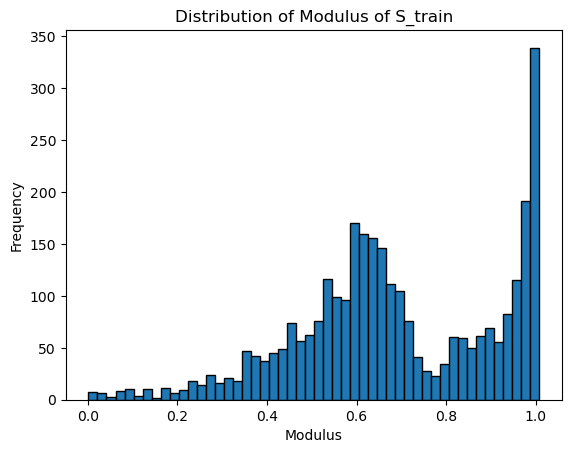

In [9]:
import matplotlib.pyplot as plt

# 计算 S_train 中所有数字的模长
modulus_S_train = np.abs(S_train.flatten())
print(modulus_S_train.shape)

# 绘制分布图
plt.hist(modulus_S_train, bins=50, edgecolor='k')
plt.xlabel('Modulus')
plt.ylabel('Frequency')
plt.title('Distribution of Modulus of S_train')
plt.show()

S_train.shape: (60, 52)


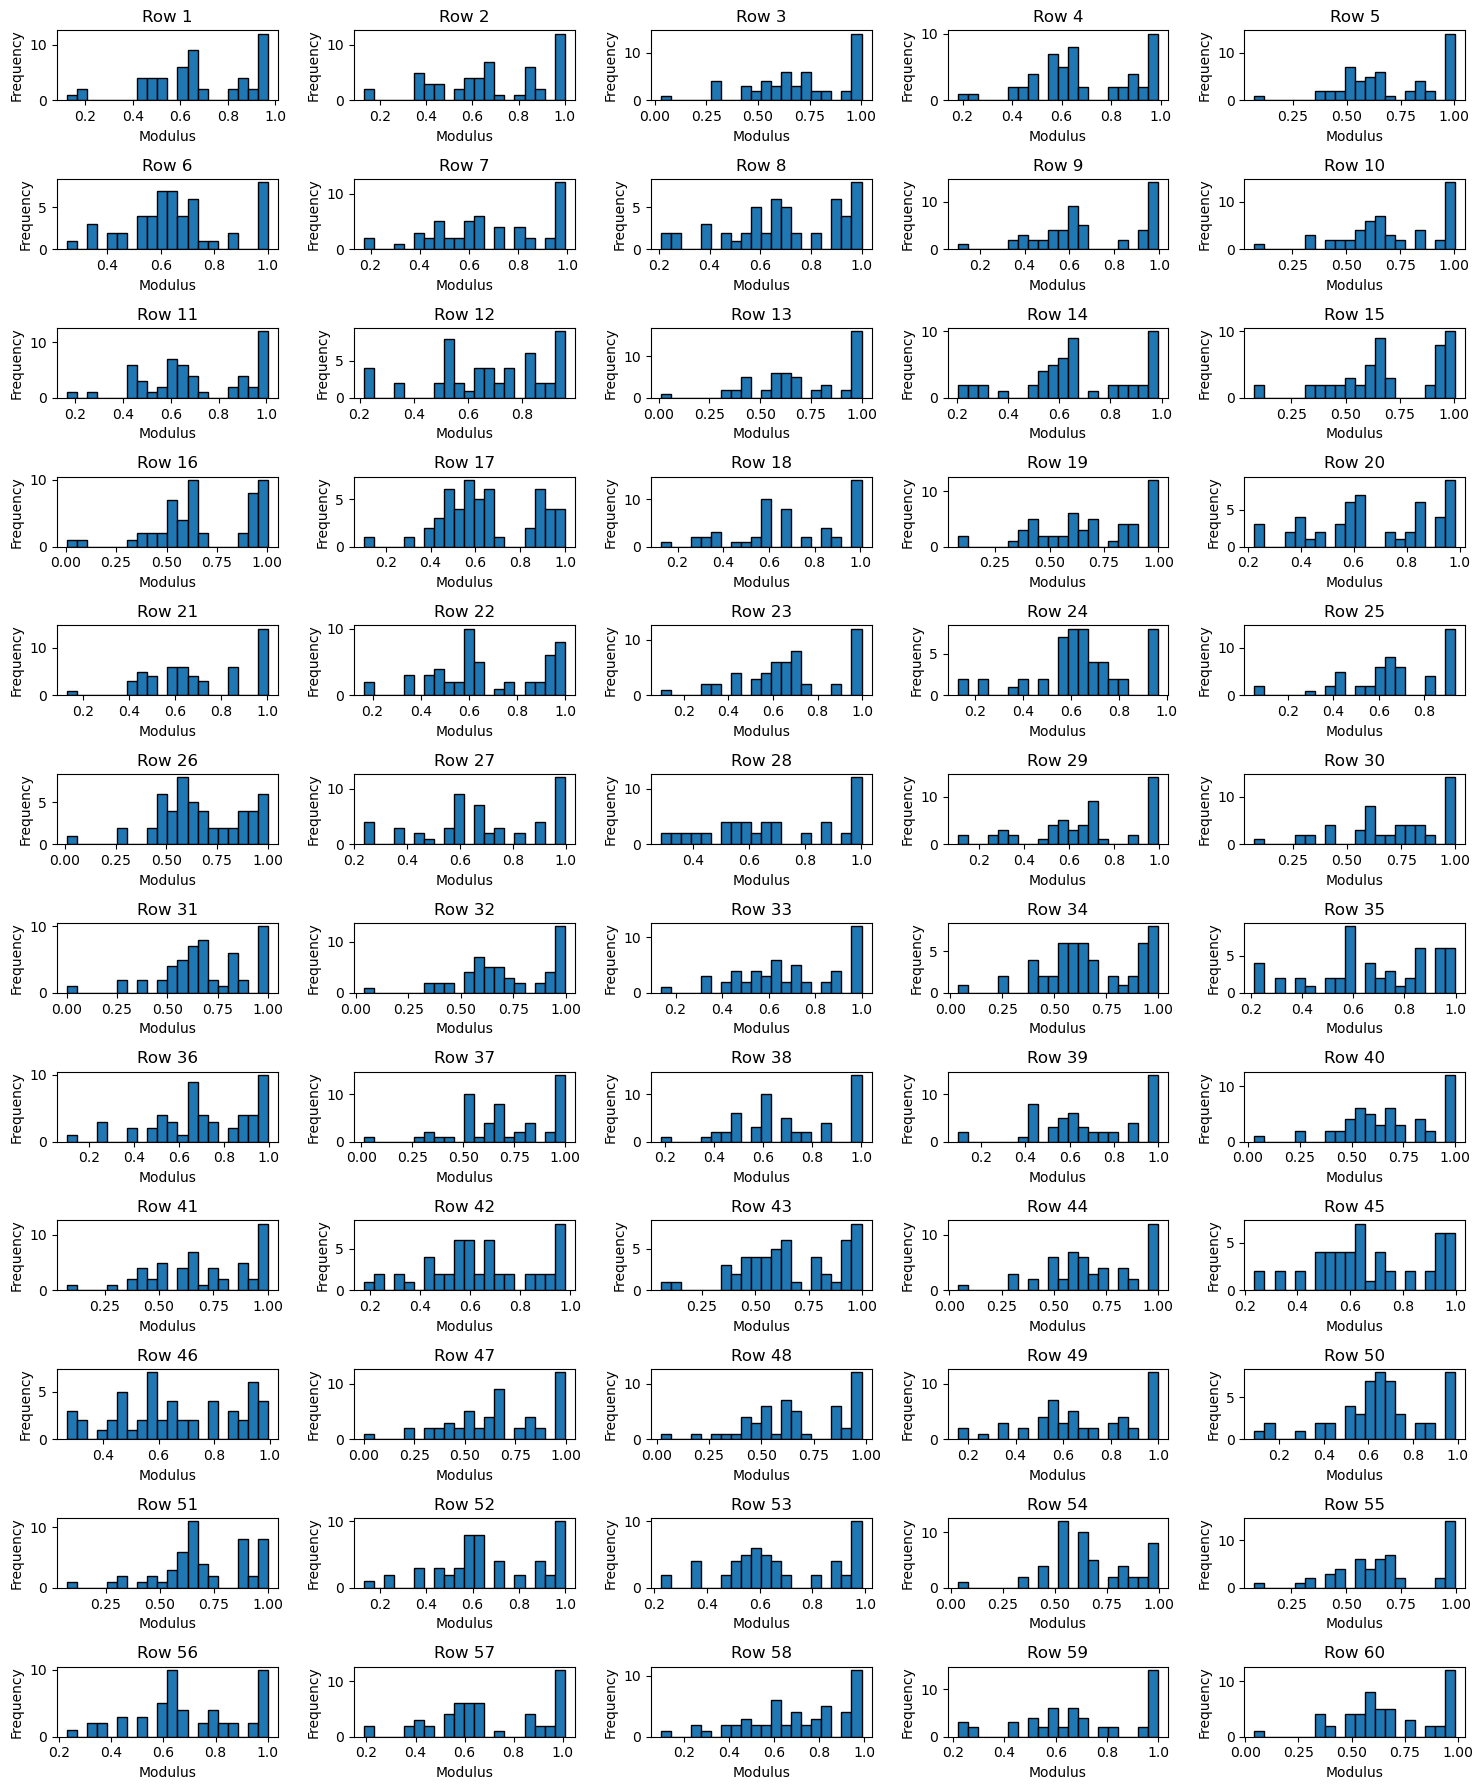

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 确保 S_train 已定义
if 'S_train' not in locals() or S_train is None or S_train.size == 0:
    raise ValueError("S_train is empty or not defined correctly.")

# 检查 S_train 形状
print(f"S_train.shape: {S_train.shape}")  # 确保是 (60, 52)

# 创建 12 行 × 5 列的子图布局
fig, axes = plt.subplots(nrows=12, ncols=5, figsize=(15, 18))
axes = axes.flatten()  # 将 (12, 5) 的二维数组展平为 1D 数组，方便索引

for i in range(60):  # 遍历 S_train 的 60 行
    ax = axes[i]  # 选取对应的子图
    modulus_S = np.abs(S_train[i, :])  # 计算模长

    # 画直方图
    ax.hist(modulus_S, bins=20, edgecolor='k')
    ax.set_title(f"Row {i+1}")
    ax.set_xlabel("Modulus")
    ax.set_ylabel("Frequency")

# 调整布局，避免子图重叠
plt.tight_layout()

# 显示图像
plt.show()


(3120,)


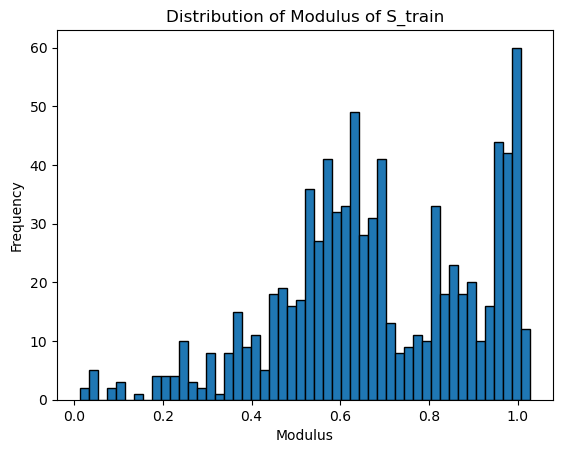

In [11]:
import matplotlib.pyplot as plt

# 计算 S_train 中所有数字的模长
modulus_S_test = np.abs(S_test.flatten())
print(modulus_S_train.shape)

# 绘制分布图
plt.hist(modulus_S_test, bins=50, edgecolor='k')
plt.xlabel('Modulus')
plt.ylabel('Frequency')
plt.title('Distribution of Modulus of S_train')
plt.show()

S_test.shape: (16, 52)


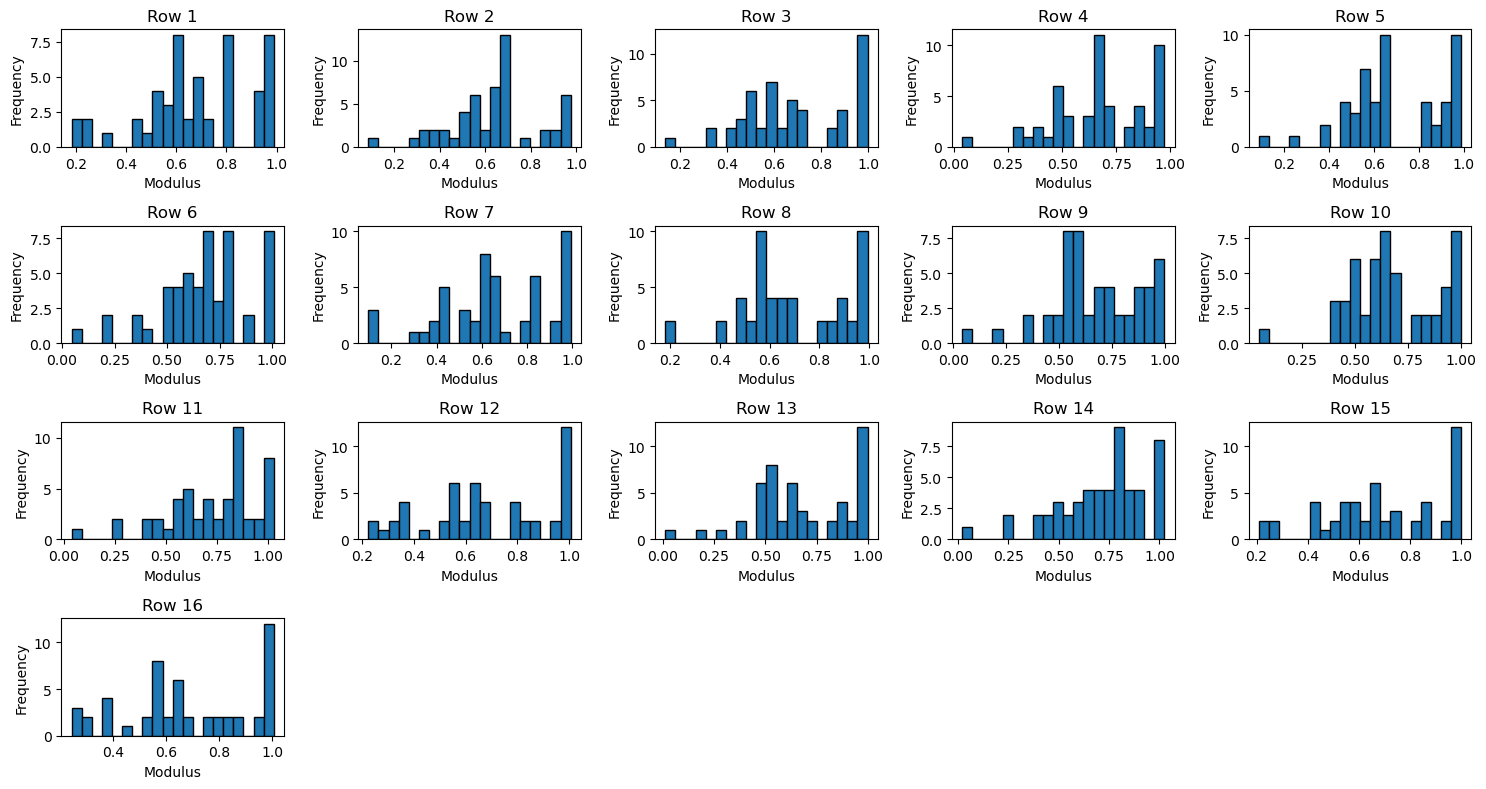

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math  # 用于向上取整

# 确保 S_test 已定义
if 'S_test' not in locals() or S_test is None or S_test.size == 0:
    raise ValueError("S_test is empty or not defined correctly.")

# 获取 S_test 形状
num_rows, num_cols = S_test.shape
print(f"S_test.shape: {S_test.shape}")  # 确保 shape 正确

# 自动计算行数和列数
cols = 5  # 默认 5 列
rows = math.ceil(num_rows / cols)  # 计算需要的行数

# 创建子图
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 2))
axes = axes.flatten()  # 展平子图网格，方便索引

# 遍历 S_test 的每一行，绘制直方图
for i in range(num_rows):
    ax = axes[i]  # 选取对应的子图
    modulus_S = np.abs(S_test[i, :])  # 计算模长

    # 画直方图
    ax.hist(modulus_S, bins=20, edgecolor='k')
    ax.set_title(f"Row {i+1}")
    ax.set_xlabel("Modulus")
    ax.set_ylabel("Frequency")

# 关闭多余的空白子图（如果有的话）
for j in range(num_rows, len(axes)):  
    fig.delaxes(axes[j])

# 调整布局，避免子图重叠
plt.tight_layout()

# 显示图像
plt.show()
